In [1]:
#https://www.kaggle.com/c/titanic

In [74]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from tempfile import mkdtemp

In [85]:
from sklearn.dummy import DummyClassifier
import xgboost as xgb

from sklearn.model_selection import cross_val_score

from sklearn.pipeline import Pipeline

import scikitplot as skplt

In [5]:

from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion, make_union
from sklearn.base import TransformerMixin, BaseEstimator, RegressorMixin

In [6]:
test= pd.read_csv(r'C:\Users\Seba\Documents\python\datasets-pyth\titanic\test.csv')
train= pd.read_csv(r'C:\Users\Seba\Documents\python\datasets-pyth\titanic\train.csv')

In [7]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [106]:
train_modified = train.copy()
X_train = train_modified[[x for x in train.columns if x not in ['Survived','PassengerId']]]
y_train = train_modified['Survived']
X_test = test[[x for x in train.columns if x not in ['Survived','PassengerId']]]

In [122]:
def train_and_predict(model, X, y):
    model.fit(X, y)
    skplt.estimators.plot_learning_curve(model, X, y, title='Learning Curve',figsize=(15, 5), cv=3, scoring='accuracy')
    print('ACCURACY:',np.mean(cross_val_score(model,X,y,cv=3,scoring='accuracy')))
     

ACCURACY: 0.6161634548992531


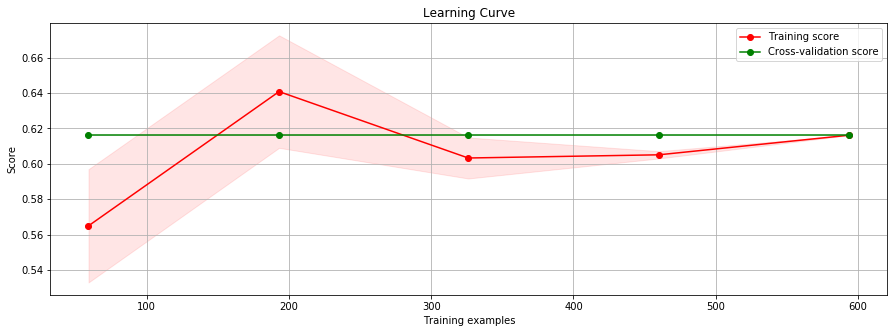

In [118]:
train_and_predict(DummyClassifier(strategy = 'prior'),X_train,y_train)

In [18]:
class DFTransform(TransformerMixin, BaseEstimator):
    def __init__(self, func, copy=False):
        self.func = func
        self.copy = copy
        
    def fit(self, *_):
        return self

    def transform(self, X):
        X_ = X if not self.copy else X.copy()
        return self.func(X_)


In [94]:
def title_label(df,feat):
    
    popular_titles = ["mr", "miss", "mrs", "master", "dr", "rev"]
    df['title'] = df['Name'].map(lambda x: x.split(',')[1].split('.')[0].lower().strip() ).map(lambda x: x if x in popular_titles else "other")
    
    return df

In [52]:
def factorize_columns(df):
    for x in df.select_dtypes(include=[object]).columns:
        df[x] = pd.factorize(df[x])[0]
    return df

In [109]:
def missing_ages(df):
    missing_ages = df.groupby('title')['Age'].agg([np.mean, np.median]).to_dict()['median']
    df['Age'] = df.apply( lambda x: x['Age'] if str(x['Age']) != 'nan' else missing_ages[x['title_norm']], axis=1 )
    return df

In [114]:
#feature 
pipeline_for_transform = Pipeline( [
    ('fill_na', DFTransform(lambda X_train: X_train.fillna(-1), copy=True)),
    ('title' , DFTransform(lambda X_train : title_label(X_train,'Name'))),
    ('missing_ages',DFTransform(lambda X_train: missing_ages(X_train))), 
    ('factorize_columns',DFTransform(lambda X_train: factorize_columns(X_train)) )
    
])

In [115]:
pipeline_for_transform.fit_transform(X_train)

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,title
0,3,0,0,22.0,1,0,0,7.2500,0,0,0
1,1,1,1,38.0,1,0,1,71.2833,1,1,1
2,3,2,1,26.0,0,0,2,7.9250,0,0,2
3,1,3,1,35.0,1,0,3,53.1000,2,0,1
4,3,4,0,35.0,0,0,4,8.0500,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
886,2,886,0,27.0,0,0,677,13.0000,0,0,5
887,1,887,1,19.0,0,0,678,30.0000,146,0,2
888,3,888,1,-1.0,1,2,614,23.4500,0,0,2
889,1,889,0,26.0,0,0,679,30.0000,147,1,0


ACCURACY: 0.8092031425364757


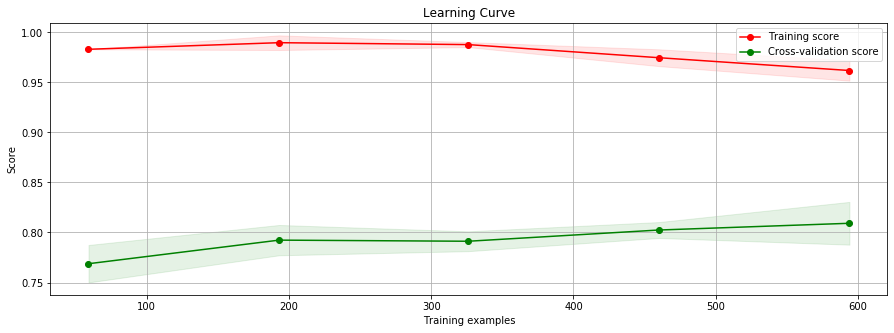

In [126]:
pipeline = Pipeline( [
    ('fill_na', DFTransform(lambda X_train: X_train.fillna(-1), copy=True)),
    ('title' , DFTransform(lambda X_train : title_label(X_train,'Name'))),
    ('missing_ages',DFTransform(lambda X_train: missing_ages(X_train))), 
    ('factorize_columns',DFTransform(lambda X_train: factorize_columns(X_train)) ),
    ('model', xgb.XGBClassifier(max_depth=5,n_estimators=100))
])

train_and_predict(pipeline, X_train, y_train)